In [1]:
!pip install torchinfo


In [1]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
---
matplotlib version: 3.7.1
pandas version: 1.5.3
PIL version: 9.4.0
torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [4]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [6]:
data_dir = os.path.join(r"C:\Users\Dickson\chest CT\Data")
train_dir = os.path.join(data_dir, "train")

print("Will read data from", train_dir)

Will read data from C:\Users\Dickson\chest CT\Data\train


In [7]:
dataset = datasets.ImageFolder(train_dir, transform=transform)

In [8]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
That's 4 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [9]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


**Prepare Our Data**

As we were reading in the data, we already did some preparation. Our images are all the same shape, and have been converted to tensors. But neural networks tend to perform best with data that has a mean of  0
  and a standard deviation of  1
 . Data that has that property is called normalized. In our case, that would be the mean and standard deviation of all of the pixels in all of the images.

Let's see what they are for our data. Here's a function that computes the mean and standard deviation for each color channel (red, green, and blue) separately. It takes in a DataLoader and returns the mean and standard deviation of each channel

In [10]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [11]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/20 [00:00<?, ?it/s]

Mean: tensor([0.3256, 0.3255, 0.3256])
Standard deviation: tensor([0.2676, 0.2676, 0.2676])


Now that we have these values, we can adjust our pixels. To get mean  0
 , we need to subtract our measured mean from every pixel. To get standard deviation  1
 , we divide every pixel by the std.

We can perform these calculations using the Normalize transformation that torchvision gives us. We'll add it as an extra step to the transform we created earlier. Since we're doing the three color channels separately, we'll nave to give Normalize a vector with three means (and the same for standard deviation). Conveniently, that's what we have

In [12]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [13]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

norm_loader = DataLoader(dataset=norm_dataset, batch_size=32)


If this did what we wanted, the normalized data should have mean  0
  and standard deviation  1
  in each color channel.

In [14]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/20 [00:00<?, ?it/s]

Mean: tensor([5.5134e-08, 6.7800e-08, 8.2701e-08])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


**Train and validation splitting**
As always, we'll need to divide our data into two parts. We'll train our data on some of our images, and reserve some of them for validation. This will let us see how our model does on images it hasn't seen before. If it makes good predictions on the training data but not on the validation data, we'll know it has overfit.

In [15]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.1% of full data
Validation data is 19.9% of full data


We should check how many of each category we have in each of our data sets. We aren't expecting the same number of each. The different categories started with different amounts, and the training set is  4
  times as big. But we should expect the training and validation sets to have the same proportion of each category.

In [16]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [17]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/491 [00:00<?, ?it/s]

adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib          155
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa        86
normal                                              117
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    133
dtype: int64

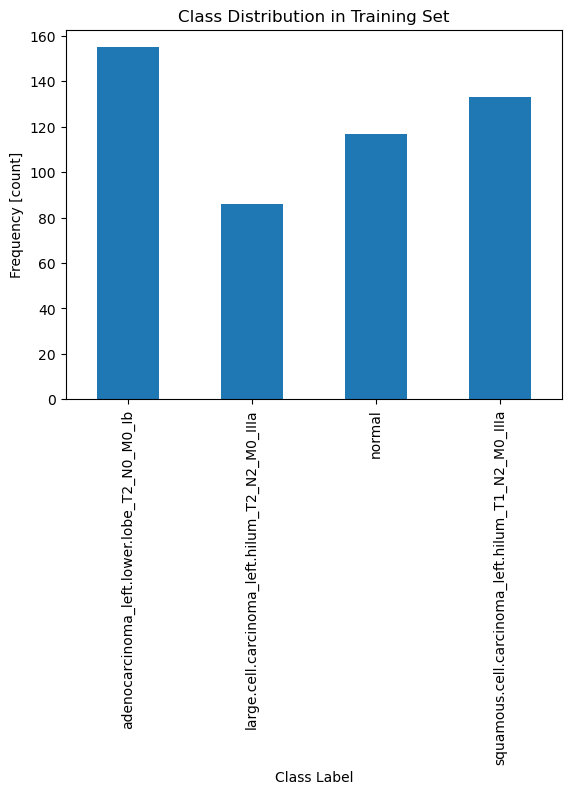

In [18]:
# Create a bar plot from train_class_distribution
train_class_distributions.plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/122 [00:00<?, ?it/s]

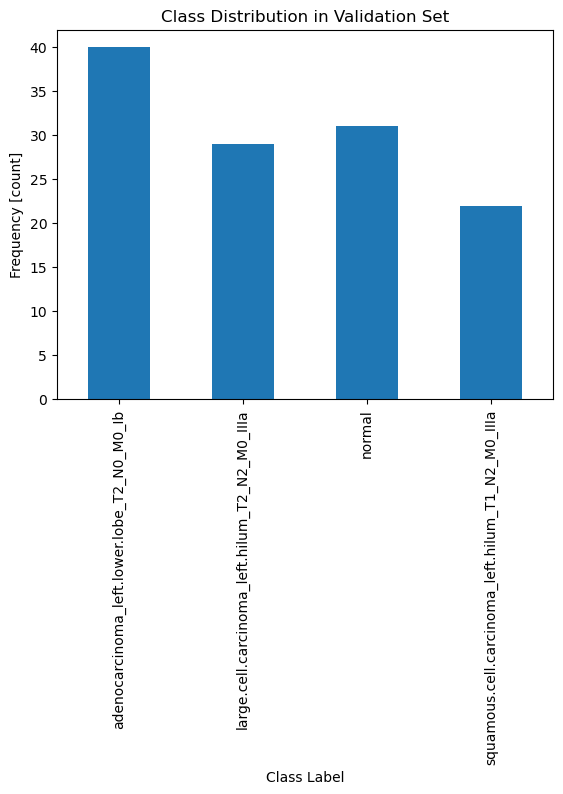

In [19]:
# Get the class distribution
validation_class_distributions = class_counts(val_dataset)

# Create a bar plot from train_class_distribution
validation_class_distributions.plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

Now that we're happy with our split, we'll need to make a DataLoader again. We'll need separate ones for the training and validation sets. But for the training data, we'll want it to be shuffled every time we run it. As in the previous notebook, we'll add shuffle=True to the arguments. We won't want the validation set shuffled.

In [20]:
g = torch.Generator()
g.manual_seed(42)


batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


**Building A Model**

**Multiclass Predictions**

Now we're going to have our model give a confidence for each class. This will give us 4
 values. As before, higher numbers mean that the model is more confident that class is the right answer. A possible output for a single image would be the following.

In [21]:
sample_confidence = torch.tensor([0.13, 0.01, 0.02, 0.12])

In [22]:
norm_dataset.classes

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [23]:
classes = norm_dataset.classes

class_number = torch.argmax(sample_confidence)
prediction = classes[class_number]

print(f"This image is a {prediction}")

This image is a adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


**Network Architecture**
Now we need a model. We'll build another neural network. The one we built last time was a shallow neural network. This is a network made of a sequence of "dense" or "fully connected" layers. But that's not the only option! You can connect the neurons in different ways, to get different architectures.

The shallow neural network is the "standard", most common one. We could use it for our problem, but to get good accuracy we'd need to add more layers. That network would take a long time to train. We'll be better served by using an architecture meant for images.

A good option, and the one we'll use, is the convolutional neural network (CNN). It consists of a sequence of convolutional and max pooling layers. These are usually followed by some fully connected layers and an output layer.

**Convolution and Max Pooling Layers**
The CNN gets its name from the convolutional layers. These layers take in an image, maintaining the 2D structure, and convolve it with a number of kernels. Each kernel will produce a new image. Thankfully, PyTorch will do all the math and tracking for us. Just like we had Linear layers before, we can get a convolutional layer by adding a Conv2D to our model.

As before, we'll use a Sequential model to keep track of how to build things.

In [24]:
model_seq = torch.nn.Sequential()

In [25]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model_seq.append(conv1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

To create a convolution layer, we need to provide it with three arguments: the number of channels it expects as input, the number of kernels to create, and the size of those kernels. We don't have to specify the size of the images, it'll figure that out.

This first layer will be looking at our input images. They have three color channels, so we set in_channels=3. For our kernels, let's start with 16
 kernels of size 3
 x 3
. We specify the kernel size with kernel_size=(3,3), and the number of kernels with out_channels=16. We'll also need padding to keep our image size. With a 3
 x 3
 kernel, we'll set padding to  1

In [26]:
test_batch = next(iter(train_loader))[0]

Let's make sure the batch is the shape we expect. It should be  32
  images, with  3
  color channels, of size  224
  x  224
 .

In [27]:
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 3, 224, 224])


In [28]:
first_step_out = model_seq(test_batch)

Now we can run the model we have so far on the data. Since we only have the one convolutional layer, we'll see its output.

This is a useful trick for making sure we're getting what we expect. What do we expect here? We should still have  32
  images, but now they should have  16
  channels corresponding to the  16
  kernels.

In [29]:
first_step_shape = first_step_out.shape

print(f"Shape after first convolution layer: {first_step_shape}")

Shape after first convolution layer: torch.Size([32, 16, 224, 224])


As always with a network, we'll need an activation function. Here we'll use the ReLU

In [30]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

Our convolution layers transform images into more images. Ultimately, we're going to need to get down to just our  8
  output classes. But our convolution has increased the number of pixels! Max pooling will let us shrink our image.

In PyTorch, this is a MaxPool2D layer. The 2D is because we're leaving the channels alone, so it'll max pool on each of our  16
  channels separately. We'll need to say how big of a patch to reduce, called the kernel again. We'll set it to  2
  x  2
 , a standard choice. We'll set our stride to  2
  as well

In [31]:
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)


Let's verify that this did what we wanted. It should have left us with  32
  images, with  16
  channels, but half as large

In [32]:
max_pool_out = model_seq(test_batch)
max_pool_shape = max_pool_out.shape

print(f"Shape after first max pool: {max_pool_shape}")

Shape after first max pool: torch.Size([32, 16, 112, 112])


This sequence of convolution, ReLU, max pool is very common in CNNs. Often networks will have several of these in a row. Let's add two more to ours.
Add a convolution layer taking in our  16
  channels and outputting  32
  channels, with a  3
  x  3
  kernel and padding of  1
 . Follow that with a ReLU, and a max pool of size  2
  x  2


In [33]:
second_conv = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
second_pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(second_conv)
model_seq.append(torch.nn.ReLU())
model_seq.append(second_pool)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

Run the current model on the test_batch, and save the output's shape to second_set_shape.

In [34]:
second_set_out = model_seq(test_batch)
second_set_shape = second_set_out.shape

print(f"Shape after second max pool: {second_set_shape}")

Shape after second max pool: torch.Size([32, 32, 56, 56])


If things went according to plan, you should now have  32
  channels and a  56
  x  56
  image.

You can actually simplify these descriptions. First, you don't have to provide the argument names for most things, IF you provide them in the right order (padding is an exception). Second, for the kernels, if you say  2
  it knows you mean  2
  x  2
  (same for  3
 , etc). Finally, for the max pool you can leave off the stride, it defaults to the size of the kernel. We can use this to make the description of our third layer set more compact. We'll use  64
  kernels this time.


In [35]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(max_pool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [36]:
third_set_out = model_seq(test_batch)
third_set_shape = third_set_out.shape

print(f"Shape after third max pool: {third_set_shape}")

Shape after third max pool: torch.Size([32, 64, 28, 28])


We're going to need an output layer with just  8
  neurons. That's a flat output, without the 3D structure of our images. Conveniently, PyTorch provides a Flatten layer for flattening. Let's add that to our model.

In [37]:
model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [38]:
flat_out = model_seq(test_batch)
flat_shape = flat_out.shape

print(f"Shape after flattening: {flat_shape}")

Shape after flattening: torch.Size([32, 50176])


In [39]:
linear1 = torch.nn.Linear(in_features=50176, out_features=500)

model_seq.append(linear1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
)

Add the ReLU activation layer.

In [40]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

In [41]:
linear_out = model_seq(test_batch)
linear_shape = linear_out.shape

print(f"Shape after linear layer: {linear_shape}")

Shape after linear layer: torch.Size([32, 500])


We could add more of these, but this network has already gotten rather large. Let's put in the final layer on. We'll need a dense layer with  8
  outputs. But this time we don't add the activation function. We need something different for the final layer.

In [42]:
output_layer = nn.Linear(in_features=500, out_features=4)
model_seq.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=4, bias=True)
)

And one final shape check. If everything has gone according to plan, we should be getting  4
  outputs for each of our input images, giving us a  32
  x  4
  tensor on our test batch.

In [43]:
model_seq(test_batch).shape

torch.Size([32, 4])

**Training the Model**

Before we start training, let's put all the model code in one place. This is how you'd do it in practice, to prevent errors.

We have also added Dropout layers after the flattened and linear layers. This helps to prevent overfitting.

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 4)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=4, bias=True)
)

And to make sure PyTorch has the model correct, let's look at the summary.

In [45]:
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [46]:
from training import train_model

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=4, bias=True)
)

In [48]:
train_model(model, train_loader, val_loader, device=device, epochs=8)


Epoch 1/8, Training Loss: 1.6206
Epoch 1/8, Validation Loss: 1.1452, Validation Accuracy: 63.93%


Epoch 2/8, Training Loss: 1.0402
Epoch 2/8, Validation Loss: 0.8293, Validation Accuracy: 51.64%


Epoch 3/8, Training Loss: 0.8233
Epoch 3/8, Validation Loss: 0.6861, Validation Accuracy: 72.95%


Epoch 4/8, Training Loss: 0.6951
Epoch 4/8, Validation Loss: 0.5534, Validation Accuracy: 77.05%


Epoch 5/8, Training Loss: 0.5105
Epoch 5/8, Validation Loss: 0.4424, Validation Accuracy: 81.15%


Epoch 6/8, Training Loss: 0.4230
Epoch 6/8, Validation Loss: 0.5983, Validation Accuracy: 77.87%


Epoch 7/8, Training Loss: 0.3703
Epoch 7/8, Validation Loss: 0.3342, Validation Accuracy: 87.70%


Epoch 8/8, Training Loss: 0.2470
Epoch 8/8, Validation Loss: 0.3351, Validation Accuracy: 88.52%
Training Complete!


In [51]:
def predict(model, data_loader, device):
    model.eval()  
    probabilities = []

    with torch.no_grad():  
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)  
            probabilities.append(probs)

    return torch.cat(probabilities) 


In [52]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)

In [53]:
predictions

tensor([0, 2, 3, 2, 2, 0, 2, 2, 3, 1, 3, 0, 2, 1, 1, 1, 3, 2, 0, 0, 3, 2, 2, 3,
        1, 3, 2, 3, 1, 0, 3, 0, 2, 0, 1, 1, 0, 0, 2, 3, 3, 3, 0, 0, 2, 0, 2, 2,
        3, 0, 1, 1, 3, 0, 2, 2, 1, 3, 3, 3, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2,
        1, 2, 1, 3, 1, 3, 2, 1, 3, 3, 1, 2, 2, 1, 2, 2, 1, 2, 3, 0, 1, 3, 1, 0,
        0, 0, 0, 3, 1, 0, 2, 0, 3, 0, 0, 2, 1, 1, 2, 2, 1, 0, 0, 3, 0, 2, 0, 1,
        2, 3])

In [54]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/4 [00:00<?, ?it/s]

### Confusion matrix

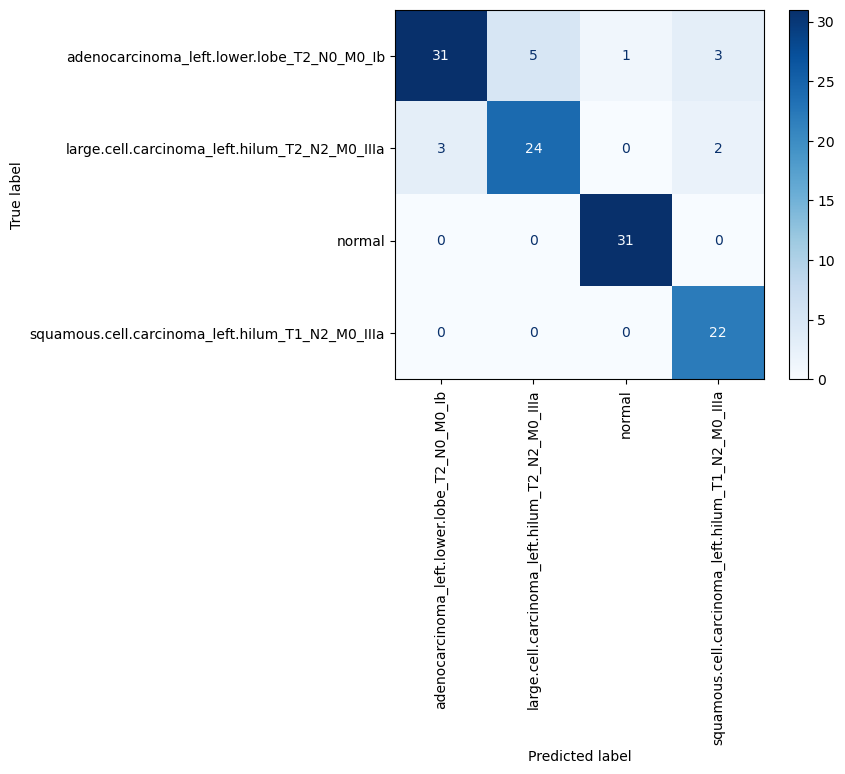

In [55]:
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

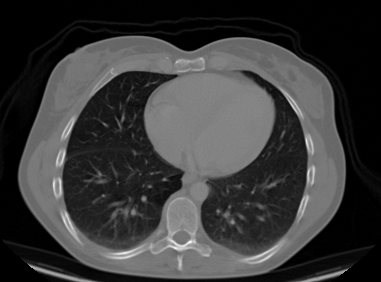

In [57]:
test_image_path = os.path.join(r"C:\Users\Dickson\chest CT\Data\test\adenocarcinoma\000108 (3).png")
test_image = PIL.Image.open(test_image_path)
test_image

In [58]:
test_image_trans = transform_norm(test_image)
test_image_trans.shape

torch.Size([3, 224, 224])

In [59]:
test_unsqueeze = test_image_trans.unsqueeze(0)
test_unsqueeze.shape

torch.Size([1, 3, 224, 224])

In [60]:
test_image_cpu = test_unsqueeze.to(device)
test_out = model(test_image_cpu)
test_out

tensor([[-0.0632,  0.5975, -1.9938,  1.0199]], grad_fn=<AddmmBackward0>)

That's the model's predictions, but it's not in the form we expected. We want a set of numbers between  0
  and  1
 , that sum to  1
 . What we're seeing is the raw output of the last layer. To convert this to the confidences, we need to run it through a SoftMax. This is very much like the logistic or sigmoid you've seen before, except that it works with many inputs. The dim=1 tells it each row is one prediction.

In [61]:
test_softmax = torch.nn.functional.softmax(test_out, dim=1)
test_softmax

tensor([[0.1657, 0.3208, 0.0240, 0.4894]], grad_fn=<SoftmaxBackward0>)

In [62]:
test_df = pd.DataFrame(test_softmax.tolist())
test_df.columns = dataset.classes

test_df

,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa,normal,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
0,0.165693,0.320824,0.024037,0.489446
